In [138]:
import torch
import torchvision
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import matplotlib.pyplot as plt
import numpy as np
from hessian import *
import operator
import itertools


In [139]:
train_data=torchvision.datasets.MNIST('./', train=True, download=True,transform=torchvision.transforms.ToTensor())
test_data=torchvision.datasets.MNIST('./', train=False, download=True,transform=torchvision.transforms.ToTensor())
# train_loader = torch.utils.data.DataLoader(train_data, batch_size=100, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_data, batch_size=100, shuffle=True)

In [140]:
train_dict={}
for (data, target) in train_data:
    if  target not in train_dict:
        train_dict[ target]=[]
        train_dict[ target].append(data)
    else:
        train_dict[ target].append(data)

In [220]:
initial_train_data=[]
initial_train_label=[]
for i in range(7):
    for j in range(0,10):
        initial_train_data.append(train_dict[i][j])
        initial_train_label.append(i)
    
print(initial_train_label)

[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6]


In [221]:
initial_train_data_tensor=torch.stack(initial_train_data)
initial_train_label_tensor=torch.tensor(initial_train_label)
train_x=torch.stack([data for (data, target) in train_data])
train_label=torch.tensor([target for (data, target) in train_data])
print(initial_train_data_tensor.size())
print(initial_train_label_tensor.size())

torch.Size([70, 1, 28, 28])
torch.Size([70])


In [258]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(1, 10, kernel_size=5)
        self.conv2 = nn.Conv2d(10, 20, kernel_size=5)
        self.fc1 = nn.Linear(320, 50)
        self.fc2 = nn.Linear(50, 20)
        
        
        
        self.q_mu=torch.tensor(np.zeros(200), dtype=torch.float, requires_grad=True)
        self.q_diag=torch.tensor(np.ones(200)*0.1, dtype=torch.float, requires_grad=True)
        params = list(self.parameters()) + [self.q_mu,self.q_diag]
        
        self.optimizer = optim.Adam(params, lr=0.001)
#         self.optimizer.param_groups.append( {'params':self.q_mu,'params': self.q_diag})
#         self.optimizer.param_groups.append( {})

        
        self.feature_optimizer = optim.Adam(self.parameters(), lr=0.001)
        self.final_optimizer = optim.Adam([ self.q_mu, self.q_diag ], lr=0.001)

    def forward(self, x, final_weight):
        x=x.view(-1,1,28,28)
        x = F.relu(F.max_pool2d(self.conv1(x), 2))
        x = F.relu(F.max_pool2d(self.conv2(x), 2))
        x = x.view(-1, 320)
        x = F.relu(self.fc1(x))
        x =self.fc2(x)
#         final_weight_sample=self.q_dis.rsample().view(20,10)
        x= torch.matmul(x,final_weight)
        return F.log_softmax(x,dim=-1)
    
    
    def feature_forward(self, x ):
        x=x.view(-1,1,28,28)
        x = F.relu(F.max_pool2d(self.conv1(x), 2))
        x = F.relu(F.max_pool2d(self.conv2(x), 2))
        x = x.view(-1, 320)
        x = F.relu(self.fc1(x))
        x =  self.fc2(x)
        return x
    
    def predict(self,x):
        with torch.no_grad():
            eps=torch.tensor(np.random.normal([200]),dtype=torch.float)
            final_weight_sample= (self.q_mu+eps*torch.sqrt(self.q_diag)).view(20,10)
            output = torch.exp(self.forward(x,final_weight_sample))
            pred = output.data.max(dim=1, keepdim=True)[1]
            return pred
        
    def test_prediction(self, x):
        with torch.no_grad():
            final_weight_mean=self.q_mu.view(20,10)
            output = torch.exp(self.forward(x,final_weight_mean))
            pred = output.data.max(dim=1, keepdim=True)[1]
            return pred
        
        
    def predictive_distribution_entropy(self,x):
        eps=torch.tensor(np.random.normal(size=[100,200]),dtype=torch.float)
        final_weight_samples=(torch.sqrt(self.q_diag).repeat(100).view(100,200)*eps+self.q_mu).view(100,20,10).permute(0, 2, 1)
        feature_of_data=self.feature_forward(x)[0]
        output_logit=final_weight_samples@feature_of_data
        output_dis=torch.distributions.categorical.Categorical(logits=output_logit)
        sample=output_dis.sample([100]).reshape([-1,1])
        entropy=-torch.mean(torch.log(torch.mean(torch.exp(output_dis.log_prob(sample)),dim=-1)))
        return entropy
    
    
    def online_train(self,x,label):
        train_losses = []
        entropy_list = []
        total_size=x.size(0)
        batch_size=50
        for it in range(0,100):
            for yo in range(0,int(total_size/batch_size)+1):
                self.final_optimizer.zero_grad()
                index=np.random.choice(x.size(0),batch_size)
                eps=torch.tensor(np.random.normal(size=[200]),dtype=torch.float)
                final_weight_sample= (self.q_mu+eps*torch.sqrt(self.q_diag)).view(20,10)
                output = self.forward(x[index],final_weight_sample)

                conditional_loss= F.nll_loss(output,label[index],reduction='sum')*(float(x.size(0))/float(batch_size))
                entropy=torch.sum(torch.log(self.q_diag))
                neg_kl=entropy-0.5 * torch.sum((self.q_diag + self.q_mu**2))
                neg_elbo=-neg_kl+conditional_loss
                neg_elbo.backward()
                self.final_optimizer.step()
                train_losses.append(neg_elbo.item())
                entropy_list.append(entropy.item())
        print(output.data.max(dim=1, keepdim=True)[1])
        plt.plot(train_losses)
        plt.show()
        plt.plot(entropy_list)
        plt.show()
        
        
    
    def pre_train(self,x,label):
        train_losses = []
        entropy_list = []
        batch_size=50
        for it in range(0,5000):
            for yo in range(0,int(x.size(0)/batch_size)+1):
                index=np.random.choice(x.size(0),batch_size)
                self.optimizer.zero_grad()

    #             conditional_loss=0
    #             for i in range(0,10):
                eps=torch.tensor(np.random.normal(size=[200]),dtype=torch.float)
                final_weight_sample= (self.q_mu+eps*torch.sqrt(self.q_diag)).view(20,10)
                output = self.forward(x[index],final_weight_sample)

                conditional_loss= F.nll_loss(output,label[index],reduction='sum')*(float(x.size(0))/float(batch_size))
    #             conditional_loss=conditional_loss/10
                entropy=torch.sum(torch.log(self.q_diag))
                neg_kl=entropy-0.5 * torch.sum((self.q_diag + self.q_mu**2))
                neg_elbo=-neg_kl+conditional_loss
                neg_elbo.backward()
                self.optimizer.step()
                train_losses.append(neg_elbo.item())
                entropy_list.append(entropy.item())
        print('labels')
        print(label[index])
        print(output.data.max(dim=1, keepdim=True)[1])
#         print(self.q_mu)
        plt.plot(train_losses)
        plt.show()
        plt.plot(entropy_list)
        plt.show()
        
        
    def test(self):
        correct=0
        for data, target in test_loader:
            pred = self.predict(data)
            correct += pred.eq(target.data.view_as(pred)).sum()
            correct_ratio= float(correct)/len(test_loader.dataset)
        return correct_ratio
    

labels
tensor([1, 3, 5, 3, 0, 4, 4, 6, 6, 3, 3, 2, 5, 5, 2, 5, 2, 1, 0, 2, 5, 0, 5, 1,
        5, 1, 6, 0, 0, 5, 0, 3, 5, 1, 5, 4, 0, 0, 0, 6, 3, 5, 6, 3, 4, 3, 3, 6,
        3, 1])
tensor([[1],
        [3],
        [5],
        [3],
        [0],
        [4],
        [4],
        [6],
        [6],
        [3],
        [3],
        [2],
        [5],
        [5],
        [2],
        [5],
        [2],
        [1],
        [0],
        [2],
        [5],
        [0],
        [5],
        [1],
        [5],
        [1],
        [6],
        [0],
        [0],
        [5],
        [0],
        [3],
        [5],
        [1],
        [5],
        [4],
        [0],
        [0],
        [0],
        [6],
        [3],
        [5],
        [6],
        [3],
        [4],
        [3],
        [3],
        [6],
        [3],
        [1]])


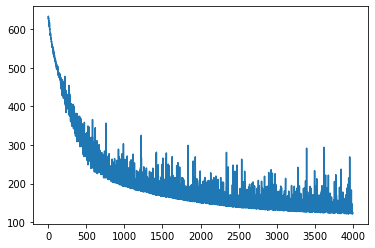

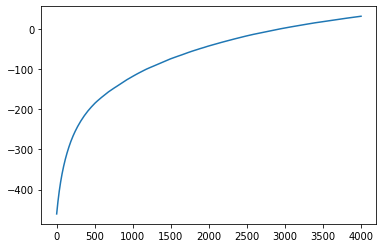

In [228]:
active_bnn = Net()
active_bnn.pre_train(initial_train_data_tensor,initial_train_label_tensor)

In [229]:
# print(active_bnn.test_prediction(initial_train_data_tensor))
# # print(active_bnn.predict(initial_train_data_tensor))
print(active_bnn.predictive_distribution_entropy(train_dict[6][20]))
print(active_bnn.predictive_distribution_entropy(train_dict[8][20]))
print(active_bnn.predictive_distribution_entropy(train_dict[8][21]))
print(active_bnn.predictive_distribution_entropy(train_dict[1][20]))
print(active_bnn.predictive_distribution_entropy(train_dict[1][1]))
print(active_bnn.predictive_distribution_entropy(train_dict[0][1]))
print(active_bnn.predictive_distribution_entropy(train_dict[4][1]))
print(active_bnn.predictive_distribution_entropy(train_dict[4][16]))
print(active_bnn.predictive_distribution_entropy(train_dict[4][15]))

tensor(0.5692, grad_fn=<NegBackward>)
tensor(2.1188, grad_fn=<NegBackward>)
tensor(1.2739, grad_fn=<NegBackward>)
tensor(0.4626, grad_fn=<NegBackward>)
tensor(0.3598, grad_fn=<NegBackward>)
tensor(0.6534, grad_fn=<NegBackward>)
tensor(0.6110, grad_fn=<NegBackward>)
tensor(1.5719, grad_fn=<NegBackward>)
tensor(0.6902, grad_fn=<NegBackward>)


In [230]:
tmp_data=initial_train_data.copy()
tmp_label=initial_train_label.copy()
print(tmp_label)
print(initial_train_label)

[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6]
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6]


In [231]:
tmp_data.append(train_dict[8][20])
tmp_data.append(train_dict[8][21])
tmp_label.append(8)
tmp_label.append(8)
print(tmp_label)

tmp_data_tensor=torch.stack(tmp_data)
tmp_label_tensor=torch.tensor(tmp_label)


print(tmp_data_tensor.size())
print(tmp_label_tensor.size())

[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 8, 8]
torch.Size([72, 1, 28, 28])
torch.Size([72])


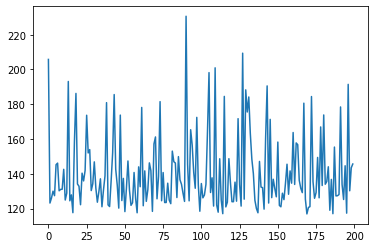

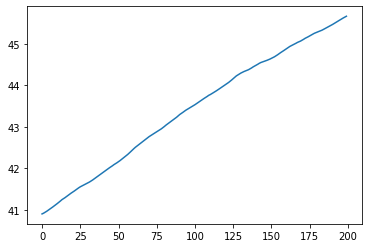

In [238]:
active_bnn.online_train(tmp_data_tensor,tmp_label_tensor)

In [239]:
print(active_bnn.predictive_distribution_entropy(train_dict[6][20]))
print(active_bnn.predictive_distribution_entropy(train_dict[8][20]))
print(active_bnn.predictive_distribution_entropy(train_dict[8][21]))
print(active_bnn.predictive_distribution_entropy(train_dict[1][20]))
print(active_bnn.predictive_distribution_entropy(train_dict[1][1]))
print(active_bnn.predictive_distribution_entropy(train_dict[0][1]))
print(active_bnn.predictive_distribution_entropy(train_dict[4][1]))
print(active_bnn.predictive_distribution_entropy(train_dict[4][16]))
print(active_bnn.predictive_distribution_entropy(train_dict[4][15]))

tensor(0.4352, grad_fn=<NegBackward>)
tensor(2.1153, grad_fn=<NegBackward>)
tensor(1.3688, grad_fn=<NegBackward>)
tensor(0.4191, grad_fn=<NegBackward>)
tensor(0.5685, grad_fn=<NegBackward>)
tensor(0.6193, grad_fn=<NegBackward>)
tensor(0.5070, grad_fn=<NegBackward>)
tensor(1.4770, grad_fn=<NegBackward>)
tensor(0.7874, grad_fn=<NegBackward>)


labels
tensor([5, 1, 1, 3, 0, 3, 5, 0, 6, 2, 1, 1, 0, 6, 5, 6, 4, 2, 2, 2, 1, 6, 0, 2,
        0, 2, 4, 1, 4, 0, 1, 1, 2, 0, 8, 5, 5, 6, 1, 0, 6, 0, 1, 0, 2, 4, 4, 1,
        5, 6])
tensor([[5],
        [1],
        [1],
        [3],
        [0],
        [3],
        [5],
        [0],
        [6],
        [2],
        [1],
        [1],
        [0],
        [6],
        [5],
        [6],
        [4],
        [2],
        [2],
        [2],
        [1],
        [6],
        [0],
        [2],
        [0],
        [2],
        [4],
        [1],
        [4],
        [0],
        [1],
        [1],
        [2],
        [0],
        [8],
        [5],
        [5],
        [6],
        [1],
        [0],
        [6],
        [0],
        [1],
        [0],
        [2],
        [4],
        [4],
        [1],
        [5],
        [6]])


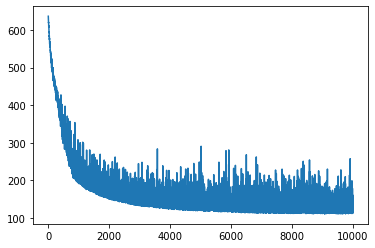

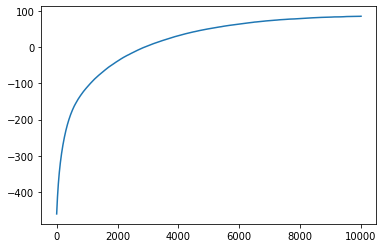

In [297]:
active_bnn = Net()
active_bnn.pre_train(tmp_data_tensor,tmp_label_tensor)

In [298]:
print(active_bnn.predictive_distribution_entropy(train_dict[6][20]))
print(active_bnn.predictive_distribution_entropy(train_dict[8][20]))
print(active_bnn.predictive_distribution_entropy(train_dict[8][21]))
print(active_bnn.predictive_distribution_entropy(train_dict[1][20]))
print(active_bnn.predictive_distribution_entropy(train_dict[1][1]))
print(active_bnn.predictive_distribution_entropy(train_dict[0][1]))
print(active_bnn.predictive_distribution_entropy(train_dict[4][1]))
print(active_bnn.predictive_distribution_entropy(train_dict[4][16]))
print(active_bnn.predictive_distribution_entropy(train_dict[4][15]))

tensor(0.5636, grad_fn=<NegBackward>)
tensor(1.8485, grad_fn=<NegBackward>)
tensor(1.8117, grad_fn=<NegBackward>)
tensor(0.6481, grad_fn=<NegBackward>)
tensor(0.2940, grad_fn=<NegBackward>)
tensor(0.5158, grad_fn=<NegBackward>)
tensor(0.6499, grad_fn=<NegBackward>)
tensor(0.9817, grad_fn=<NegBackward>)
tensor(0.8175, grad_fn=<NegBackward>)


/anaconda3/envs/rl/lib/python3.7/site-packages/ipykernel_launcher.py:1: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  """Entry point for launching an IPython kernel.


tensor([[8],
        [8],
        [8],
        [8],
        [8],
        [8],
        [8],
        [8],
        [8],
        [8],
        [8],
        [8],
        [8],
        [8],
        [8],
        [8],
        [8],
        [8],
        [8],
        [8],
        [8],
        [8],
        [8],
        [8],
        [8],
        [8],
        [8],
        [8],
        [8],
        [8],
        [8],
        [8],
        [8],
        [8],
        [8],
        [8],
        [8],
        [8],
        [8],
        [8],
        [8],
        [8],
        [8],
        [8],
        [8],
        [8],
        [8],
        [8],
        [8],
        [8]])


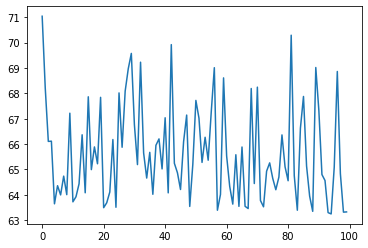

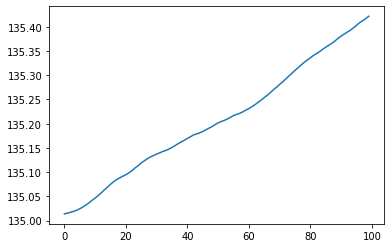

In [316]:
active_bnn.online_train(torch.tensor(train_dict[8][20]).view(-1,1,28,28),torch.tensor([8]))

In [317]:
print(active_bnn.predictive_distribution_entropy(train_dict[6][20]))
print(active_bnn.predictive_distribution_entropy(train_dict[8][20]))
print(active_bnn.predictive_distribution_entropy(train_dict[8][21]))
print(active_bnn.predictive_distribution_entropy(train_dict[1][20]))
print(active_bnn.predictive_distribution_entropy(train_dict[1][1]))
print(active_bnn.predictive_distribution_entropy(train_dict[0][1]))
print(active_bnn.predictive_distribution_entropy(train_dict[4][1]))
print(active_bnn.predictive_distribution_entropy(train_dict[4][16]))
print(active_bnn.predictive_distribution_entropy(train_dict[4][15]))

tensor(2.2586, grad_fn=<NegBackward>)
tensor(2.1932, grad_fn=<NegBackward>)
tensor(2.2263, grad_fn=<NegBackward>)
tensor(2.2847, grad_fn=<NegBackward>)
tensor(2.2463, grad_fn=<NegBackward>)
tensor(2.2371, grad_fn=<NegBackward>)
tensor(2.2412, grad_fn=<NegBackward>)
tensor(2.2753, grad_fn=<NegBackward>)
tensor(2.2686, grad_fn=<NegBackward>)
